In [45]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from ducascopy_download import *

# Functions

In [46]:
def crosscorr(data_x, data_y, lag=0):
    '''
    Lag_N cross correlation.
    Params:
    data_x, data_y: pandas series of the same length
    
    Returns:
    correlation: float
    '''
    return data_x.corr(data_y.shift(lag))

In [47]:
def window_lagged_crosscorr(data1, data2, lags_range, lag_steps, no_splits, return_corr=False):
    '''
    data1, data2: pandas series of the same length
    lags_range (int): range borders of lags (from  -lags_range to  lags_range)
    lags_steps (int): step of lags
    no_splits (int): number of splits
    return_corr (bool): whether to return correlations dataframe or not
    '''
    samples_per_split = data1.shape[0] / no_splits
    crosscorrs = []
    d1_name = data1.name
    d2_name = data2.name
    arr = np.array(range(-int(lags_range), int(lags_range+1), lag_steps))
    step = len(range(-int(lags_range), int(lags_range+1), lag_steps)) // 8
    ticks = list(np.where(np.in1d(arr, arr[::step]))[0])
    ticks_labels = list(arr[::step])
    range_val = range(-int(lags_range), int(lags_range+1), lag_steps) 
    
    for t in range(0, no_splits):
        
        d1 = data1.loc[(t)*samples_per_split:(t+1)*samples_per_split]
        d2 = data2.loc[(t)*samples_per_split:(t+1)*samples_per_split]
        window_corrs = [crosscorr(d1, d2, lag) for lag in range_val]
        crosscorrs.append(window_corrs)
        
    crosscorrs = pd.DataFrame(crosscorrs)
    f, ax = plt.subplots(figsize=(20,10))
    sns.heatmap(crosscorrs, cmap='RdBu_r', ax=ax)
    ax.set(title=f'Windowed Time Lagged Cross Correlation between \n {d1_name} and {d2_name}',
           xlabel='Offset, minutes',
           ylabel='Window number')
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks_labels, rotation=70, fontsize=14)
    plt.show()
    if return_corr == True:
        return crosscorrs
    

In [48]:
def rolling_window_lagged_crosscorr(data1, data2, lags_range, lag_steps, 
                                    window_size, step_size , return_corr=False,
                                    plot_graph = True):
    '''
    data1, data2: pandas series of the same length
    lags_range (int): range borders of lags (from  -lags_range to  lags_range)
    lags_step (int): step of lags
    window_size (int): window size
    step_size (int): step for window moving
    return_corr (bool): whether to return correlations dataframe or not
    plot_graph (bool): whether plot the correlations plot or not
    '''
    t_start = 0
    t_end = t_start + window_size
    crosscorrs = []
    idx = []
    d1_name = data1.name
    d2_name = data2.name
    arr = np.array(range(-int(lags_range), int(lags_range+1), lag_steps))
    range_val = range(-int(lags_range), int(lags_range+1), lag_steps)
    step = len(range(-int(lags_range), int(lags_range+1), lag_steps)) // 8
    ticks = list(np.where(np.in1d(arr, arr[::step]))[0])
    ticks_labels = list(arr[::step])
    
    while t_end < data1.shape[0]:
        
        d1 = data1.iloc[t_start:t_end]
        d2 = data2.iloc[t_start:t_end]
        window_corrs  = [crosscorr(d1, d2, lag) for lag in range_val]
        idx.append(t_start)
        crosscorrs.append(window_corrs)
        t_start = t_start + step_size
        t_end = t_end + step_size
        
    crosscorrs = pd.DataFrame(crosscorrs, index=idx)
    if plot_graph == True:
        f,ax = plt.subplots(figsize=(20,20))
        sns.heatmap(crosscorrs, cmap='RdBu_r', ax=ax)
        ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation between \n {d1_name } and {d2_name }',
               xlabel='Offset, minutes',
               ylabel='Window number')
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks_labels, rotation=70, fontsize=14)
        plt.show()
    if return_corr == True:
        return crosscorrs

In [49]:
def best_lags(df, arr, threshold=0.95, drop_zero_lag=True):
    
    '''
    Inputs:
    df(pd.Dataframe): dataframe with correlations between two tickers
    arr(np.array): array with lags values
    threshld(float): threshold levelfor correlation
    Returns:
    check(pd.Dataframe): dataframe with lags above threshold with window start
    '''
    top_corr_list = []
    for i in range(0, len(df)):
        
        test = pd.DataFrame()
        test['corr'] = df.iloc[i,:][df[abs(df)>threshold].iloc[i,:].notnull()]
        test.index = arr[df.iloc[i,:][df[abs(df)>threshold].iloc[i,:].notnull()].index]
        if len(test) > 0:
            name = [df.iloc[i,:].name]
            val = [[{'lag':i, 'corr':j} for i, j in zip(test.index, test.iloc[:,0])]]
            if drop_zero_lag==True:
                val = [[el for el in val[0] if el['lag']!=0]]
            if len(val[0]) != 0:
                top_corr_list.append(name+val)
            
    check = pd.DataFrame(top_corr_list)
    check.columns = ['window_start', 'lags']
    check['lags'] = check.lags.apply(lambda y: sorted(y, key=lambda x: abs(x['corr']), reverse=True))
    return check

In [50]:
def plot_corr_windows(col1, col2, lags_range, lag_step,
                                    window_size, step_size,
                                    arr, threshold=0.95):
    '''
    Inputs:
    col1,col2 pandas series of the same length
    lags_range (int): range borders of lags (from  -lags_range to  lags_range)
    lags_step (int): step of lags
    window_size (int): window size
    step_size (int): step for window moving
    arr(np.array): array with lags values
    threshld(float): threshold levelfor correlation
    '''
    
    df = rolling_window_lagged_crosscorr(
                                    col1,
                                    col2,
                                    lags_range, lag_step,
                                    window_size, step_size,
                                    return_corr=True,
                                    plot_graph=False)
    check = best_lags(df, arr, threshold)
    fig, axs = plt.subplots(2,3, figsize=(16,10))
    for i in range(0,6):
        lag, wind, corr = check.iloc[i,1][0]['lag'], check.iloc[i,0], check.iloc[i,1][0]['corr']
        name1 = col1.name
        name2 = col2.name

        data1 = col1 \
                 [wind + lag:  wind + window_size + lag].\
                 reset_index(drop = True) 
        data2 = col2 \
                 [wind:wind + window_size].reset_index(drop = True)
        data1 -= data1.mean()
        data2 -= data2.mean()
        axs[i//3, i%3].plot(data1, label = name1)
        axs[i//3, i%3].plot(data2, label = name2)
        axs[i//3, i%3].set_title(f"Window: {wind} lag:{lag} minutes corr: {round(corr,2)}" )
        axs[i//3, i%3].legend()
    plt.show()

In [51]:
def most_common_lags(df):
    '''
    Input:
    df(pd.Dataframe) : dataframe with lags above threshold with window start
    Returns:
    lag_count (dict) : dictionary with count of lags
    '''
    lags_count = {}
    for _, lag in df.iterrows():
        for el in lag[1]:

            if el['lag'] in lags_count.keys():
                lags_count[el['lag']] += 1
            else:
                lags_count[el['lag']] = 1
    lags_count = {k: lags_count[k] for k in sorted(
                                            lags_count,
                                            key=lags_count.get,
                                            reverse=True)}
    return lags_count 


# Preprossesing

In [52]:
start_day = '2021-01-01'
end_day = '2022-07-25'
symbols = ['PFEUSUSD' , 'FUSUSD', 'GWWUSUSD']
symbols_names = ['PFIZER INC', 'FORD MOTOR CO', 'WW GRAINGER INC']
fmt = '>5if'

data = download_data(symbols, symbols_names, start_day, end_day, fmt)

data.head()


100%|██████████| 570/570 [02:57<00:00,  3.21it/s]


100%|██████████| 570/570 [02:56<00:00,  3.23it/s]


100%|██████████| 570/570 [02:57<00:00,  3.21it/s]


,time,open,high,low,close,volume,Ticker Full Name
0,2021-01-01 00:00:00,36.807,36.807,36.807,36.807,0.0,PFIZER INC
1,2021-01-01 00:01:00,36.807,36.807,36.807,36.807,0.0,PFIZER INC
2,2021-01-01 00:02:00,36.807,36.807,36.807,36.807,0.0,PFIZER INC
3,2021-01-01 00:03:00,36.807,36.807,36.807,36.807,0.0,PFIZER INC
4,2021-01-01 00:04:00,36.807,36.807,36.807,36.807,0.0,PFIZER INC


In [53]:
print("Data is from {} to {}, duration: {}\n".format(data.time.min(),
                                                     data.time.max(),
                                                     data.time.max()-data.time.min()))
print(f'Number of unique tickers: {data["Ticker Full Name"].nunique()} \n')

data.info()

Data is from 2021-01-01 00:00:00 to 2022-07-24 23:59:00, duration: 569 days 23:59:00

Number of unique tickers: 3 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2462400 entries, 0 to 2462399
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   time              datetime64[ns]
 1   open              float64       
 2   high              float64       
 3   low               float64       
 4   close             float64       
 5   volume            float64       
 6   Ticker Full Name  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 131.5+ MB


In [54]:
# add timestamp column
data.loc[:, 'timestamp'] = data.time.apply(lambda x: x.timestamp())

# make min-max normalization
data.loc[:, 'norm_close'] = data.groupby('Ticker Full Name')['close'].\
                                 apply(lambda x: (x-x.min())/(x.max()-x.min())) 

In [61]:
# here we need to delete weekends and non working hours for US stocks
data = data[data.time.dt.dayofweek <5]
data = data[(data.time.dt.hour < 20) & (data.time.dt.hour + (data.time.dt.minute) / 60 > 12.5)]

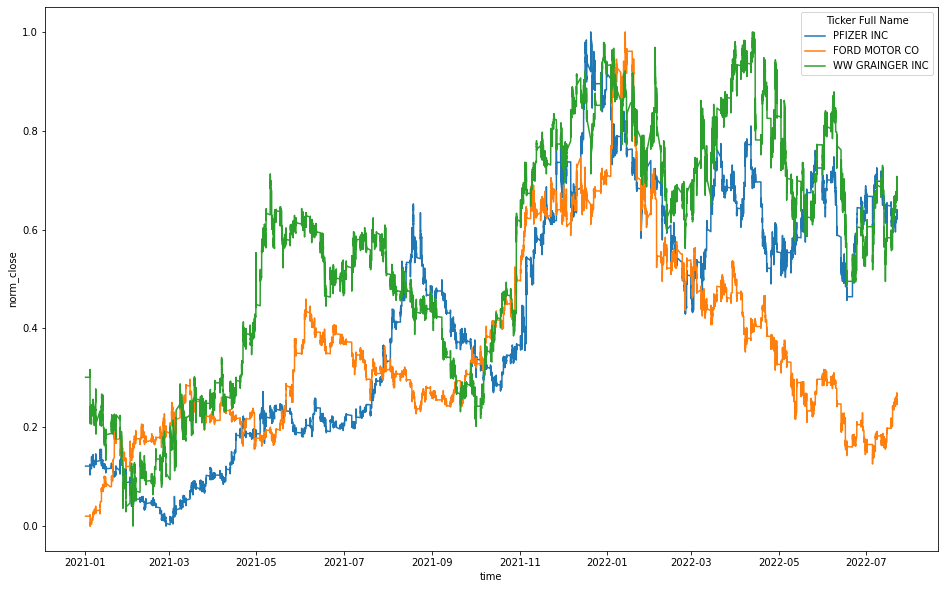

In [62]:
# plot close price for each ticker with min-max normalization
plt.figure( figsize=(16, 10))
sns.lineplot(data=data,
             hue="Ticker Full Name",
             x="time",
             y='norm_close')
plt.show()

For easier work with data lets transform it form long to wide format.  
As previous graph shows data has 3 unique tickers so we will have three new columns instead of one.   
To fill NA values we will use last non NA value.  

In [63]:
data_pivot = data.pivot(index='time', 
                        columns='Ticker Full Name',
                        values='norm_close')

data_pivot = data_pivot.fillna(method='ffill')
data_pivot = data_pivot.reset_index()
data_pivot.columns.name = None
data_pivot.head()

,time,FORD MOTOR CO,PFIZER INC,WW GRAINGER INC
0,2021-01-01 12:31:00,0.020138,0.121399,0.301154
1,2021-01-01 12:32:00,0.020138,0.121399,0.301154
2,2021-01-01 12:33:00,0.020138,0.121399,0.301154
3,2021-01-01 12:34:00,0.020138,0.121399,0.301154
4,2021-01-01 12:35:00,0.020138,0.121399,0.301154


# Windowed correlation plots

We want to build correlation plot for several windows.  
Here we define number of windows (*no_splits*) 15, we will search lags (*lags_range*) in range of $\pm 10$  days with step (*lag_steps*) equal of 30 minutes

In [64]:
lags_range = 60 * 24 * 10
lag_steps = 30
no_splits = 15

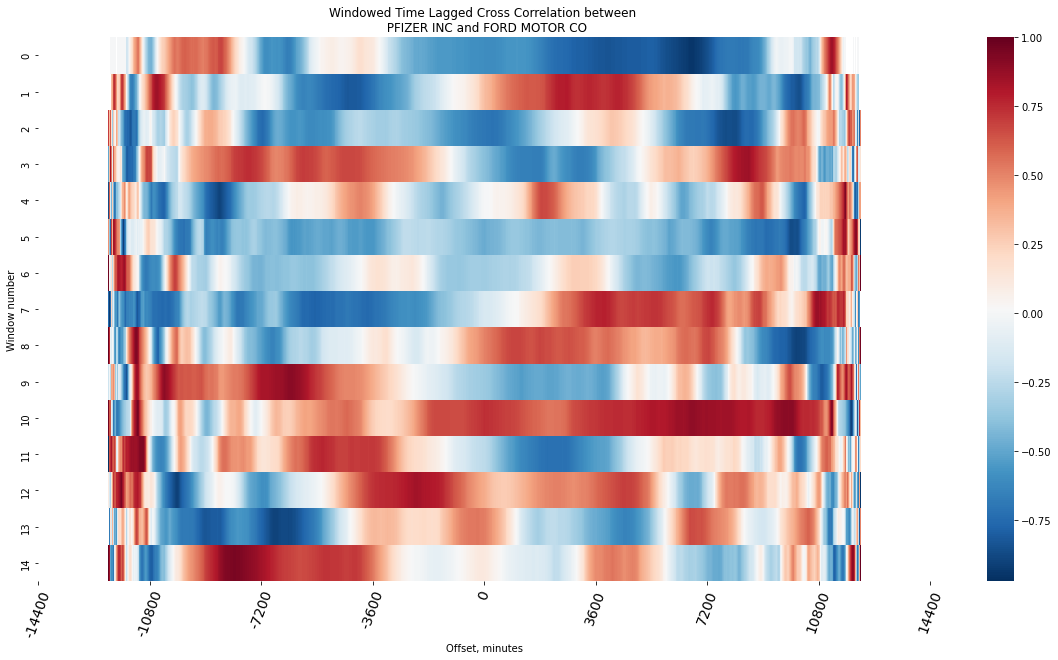

In [65]:
window_lagged_crosscorr(data_pivot.loc[:, symbols_names[0]],
                        data_pivot.loc[:, symbols_names[1]],
                        lags_range, lag_steps, no_splits)

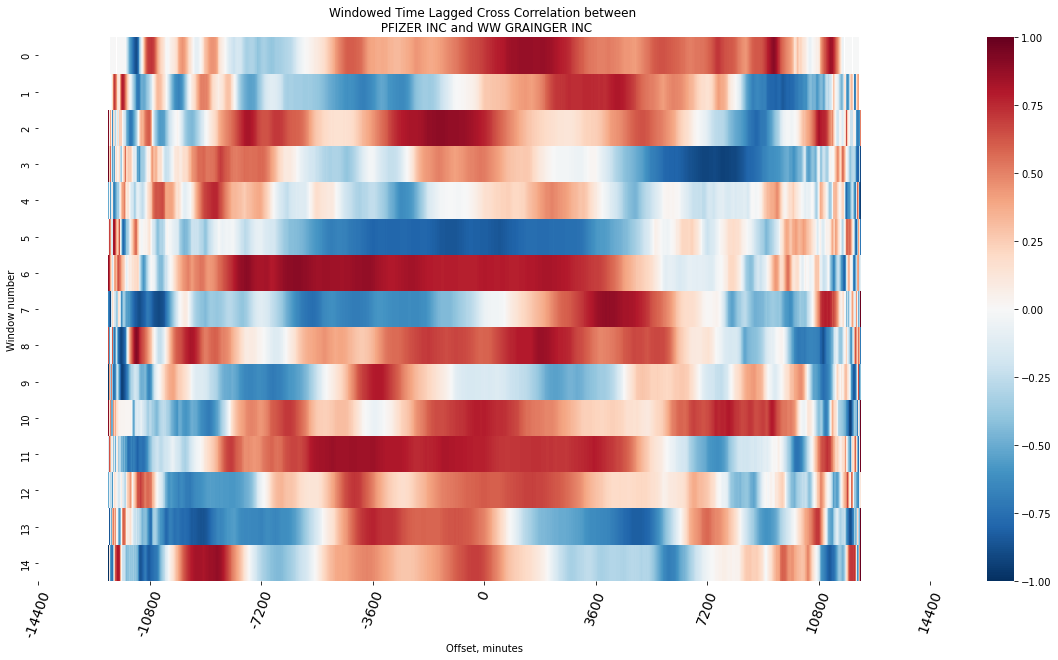

In [66]:
window_lagged_crosscorr(data_pivot.loc[:, symbols_names[0]],
                        data_pivot.loc[:, symbols_names[2]],
                        lags_range, lag_steps, no_splits)

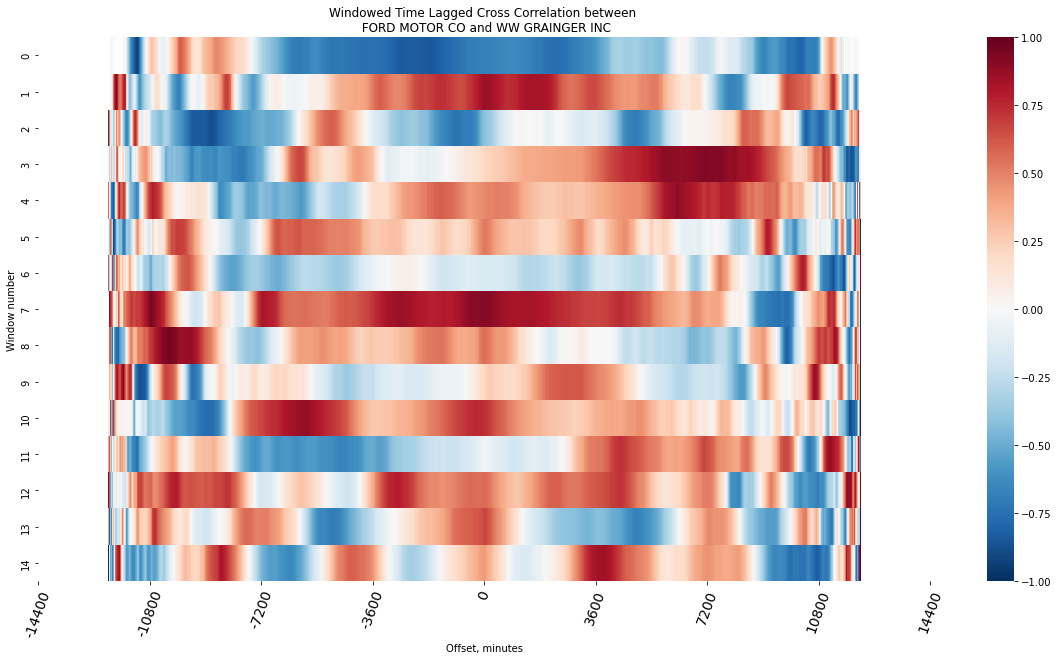

In [67]:
window_lagged_crosscorr(data_pivot.loc[:, symbols_names[1]],
                        data_pivot.loc[:, symbols_names[2]],
                        lags_range, lag_steps, no_splits)

We can see that there are no constant lag connection in all pairs of the data. But as we look closely on these graphs, sometimes we can see high correlation, hense we can assume there is a lag connection. For example there is lag connection with {{ symbols_names[0] }} and {{ symbols_names[1] }} on the 10th window with lag appoximately 5 days.

# Rolling windowed time lagged correlation plots

We want to build rolling window correlation plot for several windows.  
Here we define length of window (*window_size*) equal for 2 days , we will search lags (*lags_range*) in range of $\pm 2$  days with step (*lag_step*) equal of 30 minutes. Window is moved by one day. (*arr*) is numpy array of lag indexes.

In [68]:
lags_range = 60 * 24 * 2
lag_step = 30
window_size = 60 * 24 * 2
step_size = 60 * 24
arr = np.array(range(-int(lags_range), int(lags_range+1), lag_step))

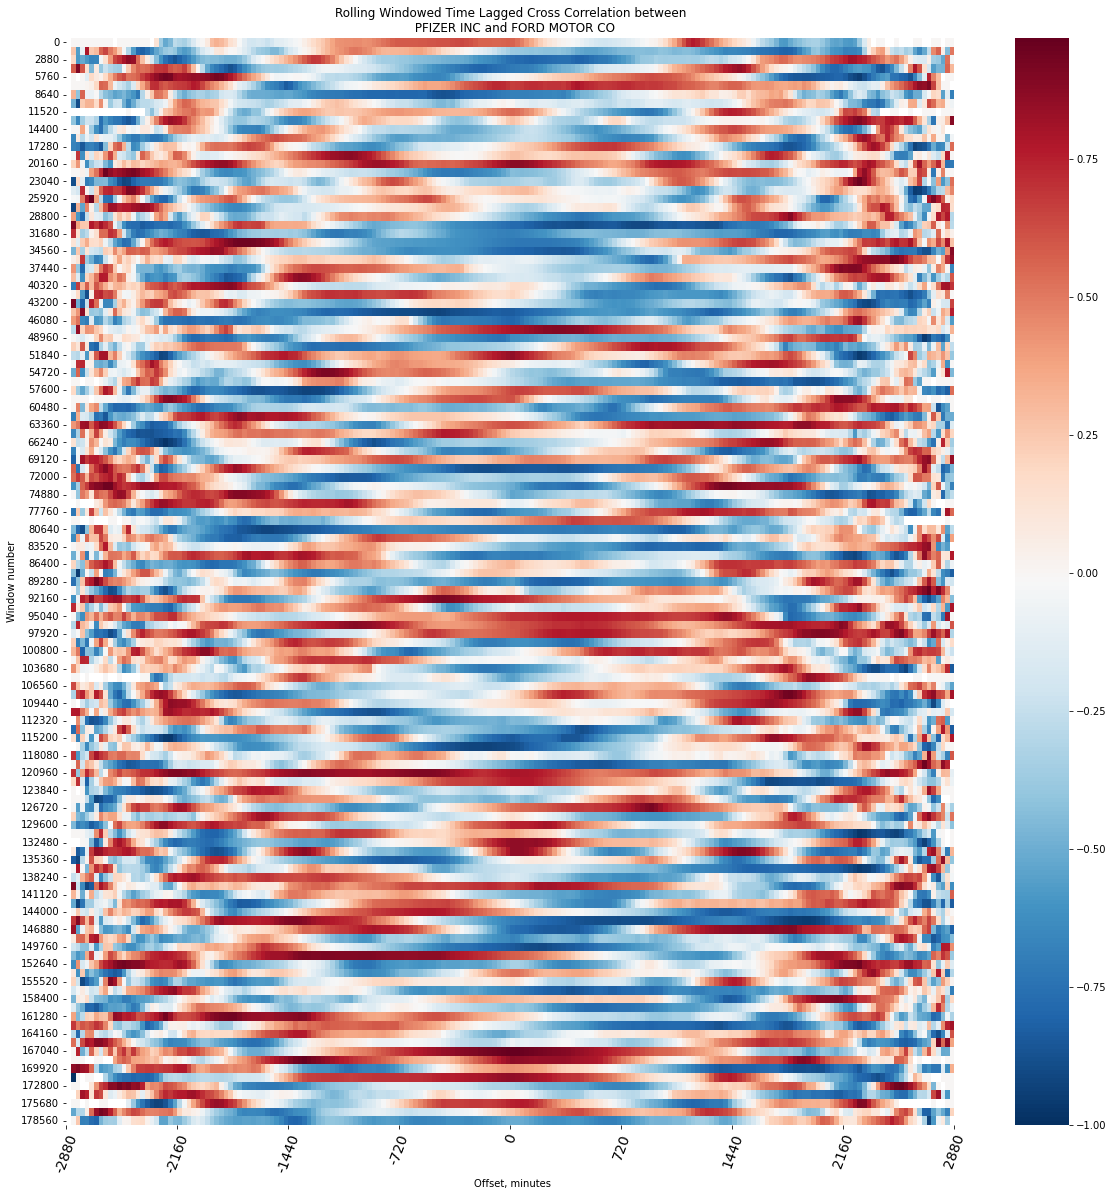

In [69]:
df_0_vs_1 = rolling_window_lagged_crosscorr(
                                    data_pivot.loc[:, symbols_names[0]],
                                    data_pivot.loc[:,symbols_names[1]],
                                    lags_range, lag_step,
                                    window_size, step_size,
                                    return_corr=True)

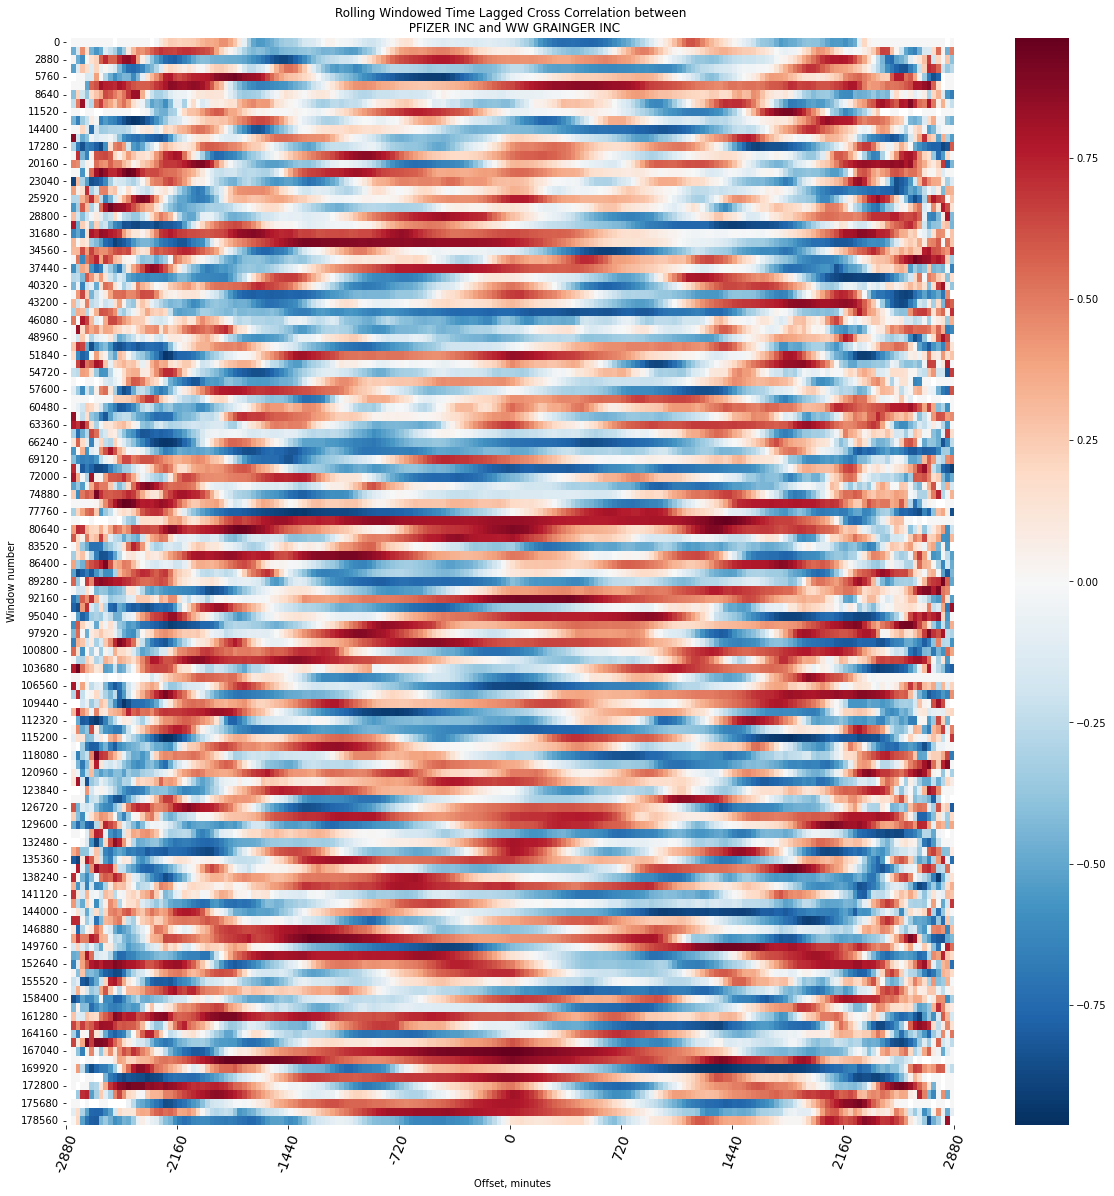

In [70]:
df_0_vs_2 = rolling_window_lagged_crosscorr(
                                    data_pivot.loc[:, symbols_names[0]],
                                    data_pivot.loc[:, symbols_names[2]],
                                    lags_range, lag_step,
                                    window_size, step_size,
                                    return_corr=True)

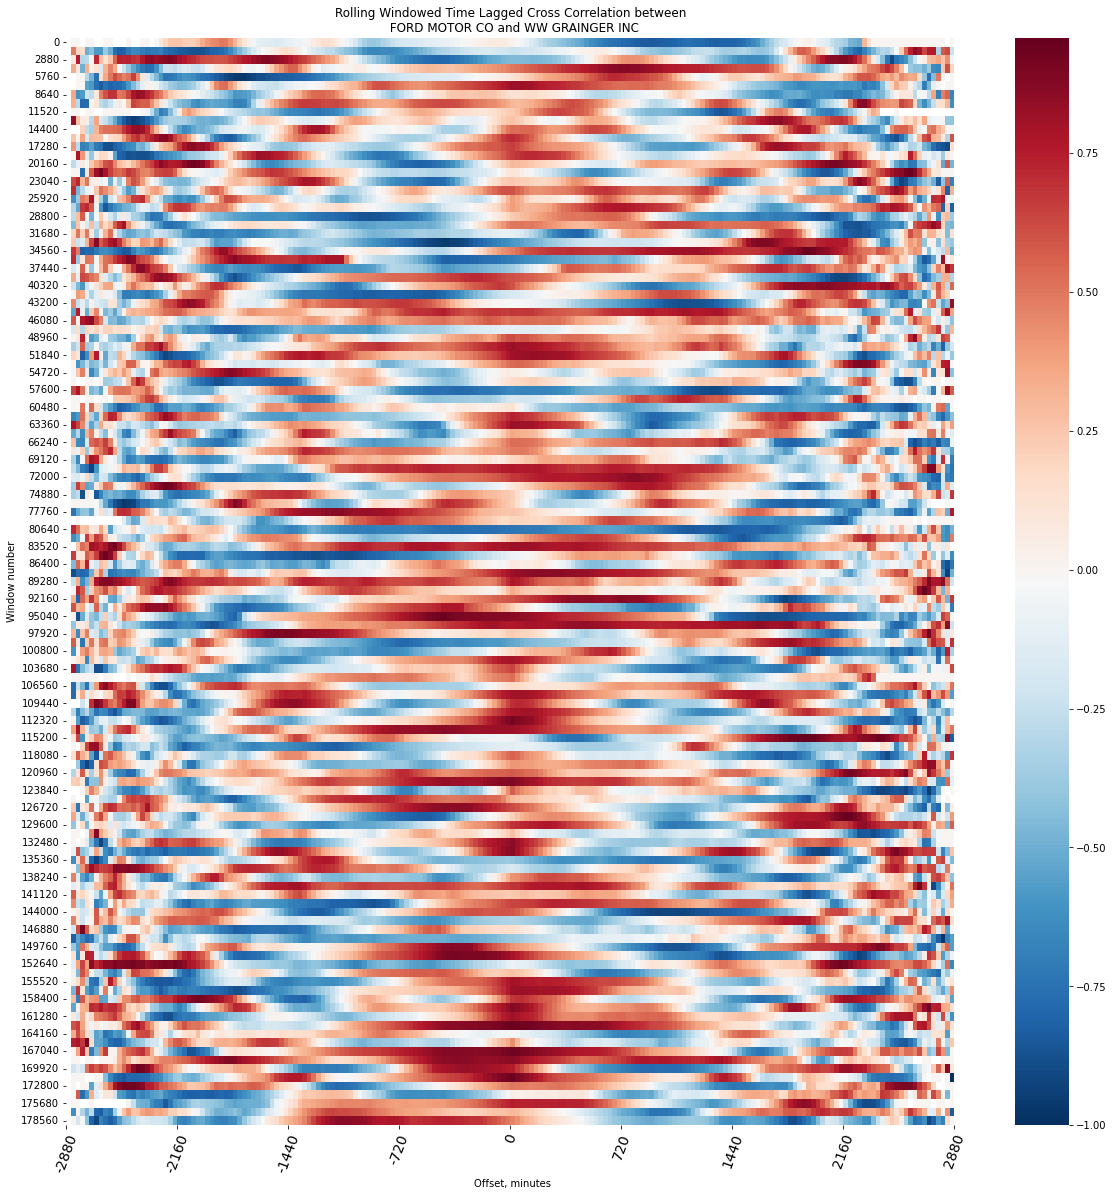

In [71]:
df_1_vs_2 = rolling_window_lagged_crosscorr(
                                    data_pivot.loc[:, symbols_names[1]],
                                    data_pivot.loc[:, symbols_names[2]],
                                    lags_range, lag_step,
                                    window_size, step_size,
                                    return_corr=True)

We saved dataframes (format: df_\[feature1\]_vs_\[feature2\]) with correlation data, here we show their typical view.  
Index describes start of the window, column is number of lag, data is the correlation between ticker and lagged ticker.

In [72]:
df_0_vs_1.head()

,0,1,2,3,4,5,6,7,8,9,...,183,184,185,186,187,188,189,190,191,192
0,NaN,-9.574843e-15,-8.626071e-17,2.749222e-16,-1.728861e-15,-2.896604e-15,-1.198489e-15,-2.219237e-15,-2.279214e-15,-2.790166e-15,...,-6.530580e-16,-2.812870e-16,NaN,NaN,-3.359981e-15,1.000482e-15,NaN,-3.169892e-16,1.530780e-14,NaN
1440,NaN,2.552169e-01,-5.688432e-01,-8.652835e-02,7.895276e-01,2.509387e-01,2.977514e-01,5.654766e-01,6.491676e-01,5.003911e-01,...,-5.309737e-01,-6.575578e-01,-0.520979,-0.265362,4.584566e-01,5.636450e-01,0.040099,-4.415751e-01,5.006590e-01,NaN
2880,NaN,1.710863e-01,-5.806361e-01,-5.189252e-01,-5.894230e-01,-6.713387e-01,-6.654623e-01,-3.915394e-02,1.505941e-01,4.096139e-01,...,-1.268342e-01,-1.608961e-01,-0.168772,0.039984,-3.562360e-01,-3.879857e-01,-0.524583,5.306701e-01,-4.369304e-02,NaN
4320,NaN,5.794399e-01,9.044311e-01,6.075678e-01,1.507166e-01,-4.590009e-01,7.524563e-02,-3.968754e-01,-2.382848e-01,-3.120656e-01,...,7.921075e-01,6.117983e-01,0.144251,-0.186949,-5.617560e-01,-4.747135e-01,-0.481574,5.596465e-01,3.077353e-01,NaN
5760,NaN,-5.769016e-15,NaN,-4.195293e-14,-1.270305e-01,1.806466e-01,7.875783e-02,3.760807e-02,1.785807e-01,3.437844e-01,...,-6.753640e-01,-4.453155e-01,-0.130492,0.752768,4.757932e-01,2.913887e-01,NaN,1.654189e-14,-6.840625e-14,NaN


# Top correlations for lags

In this section we will see some plots of one ticker vs another.  
We will use lags for the best correlations and overplot graphs with lagged shift.

In [73]:
threshold_0_vs_1 = best_lags(df_0_vs_1,  arr, threshold=0.95)
threshold_0_vs_1.head()

,window_start,lags
0,24480,"[{'lag': 2610, 'corr': -0.9541271340396762}]"
1,25920,"[{'lag': -2730, 'corr': 0.9545469505731672}]"
2,48960,"[{'lag': 2670, 'corr': -0.9557668176151294}]"
3,51840,"[{'lag': 2250, 'corr': -0.9552738158924339}]"
4,66240,"[{'lag': -2250, 'corr': -0.9789421736225072}]"


In [74]:
most_common_lags(threshold_0_vs_1)

{2250: 3,
 -2250: 2,
 2610: 1,
 -2730: 1,
 2670: 1,
 2700: 1,
 -2220: 1,
 2280: 1,
 1890: 1,
 1920: 1,
 -30: 1,
 30: 1,
 -60: 1,
 60: 1,
 -90: 1,
 90: 1,
 -1350: 1,
 -1380: 1,
 -2850: 1}

We can see that in 3 windows  {{ symbols_names[0] }} is led by {{ symbols_names[1] }} with lag of 2250 minutes. And in 2 windows we see opposite relationship with same lag.
                                    

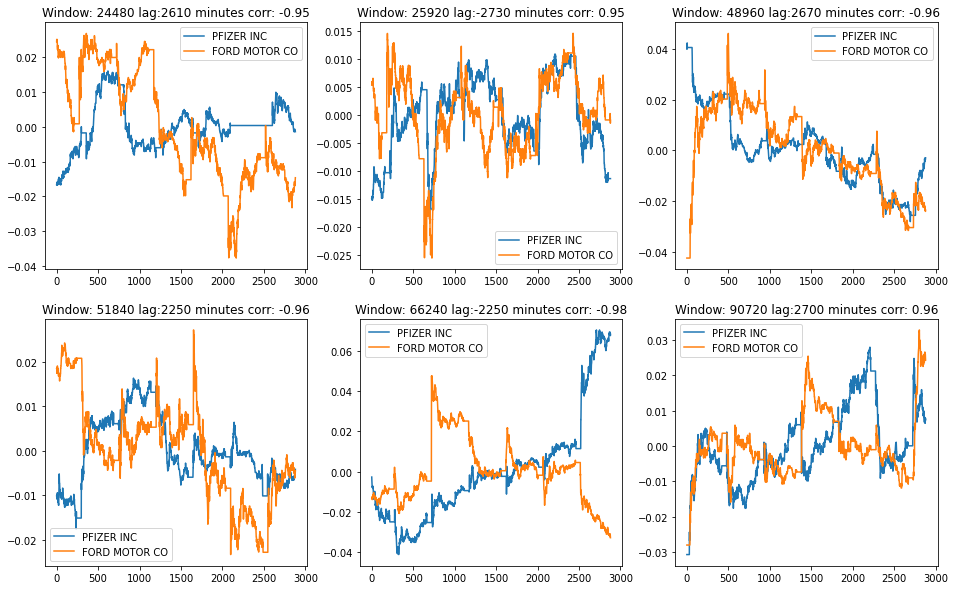

In [75]:
plot_corr_windows(data_pivot.loc[:, symbols_names[0]],
                  data_pivot.loc[:, symbols_names[1]],
                  lags_range, lag_step,
                  window_size, step_size,
                  arr)

In [76]:
threshold_0_vs_2 = best_lags(df_0_vs_2, arr, threshold=0.95)
threshold_0_vs_2.head()

,window_start,lags
0,21600,"[{'lag': -2490, 'corr': 0.9533261386741786}]"
1,76320,"[{'lag': -2520, 'corr': 0.9592438754447913}]"
2,79200,"[{'lag': 1380, 'corr': 0.9563977335770608}, {'..."
3,80640,"[{'lag': -1770, 'corr': 0.9522036495991162}]"
4,115200,"[{'lag': -2250, 'corr': -0.963614230708156}, {..."


In [77]:
most_common_lags(threshold_0_vs_2)

{1350: 2,
 -1770: 2,
 -2490: 1,
 -2520: 1,
 1380: 1,
 -2250: 1,
 1800: 1,
 -2220: 1,
 -30: 1,
 -60: 1,
 30: 1,
 -90: 1,
 -1830: 1,
 -1800: 1,
 -1860: 1}

In {{ symbols_names[0] }} and {{ symbols_names[2] }} pair lag connection is weak.  
We see that maximum lag connection is no more than 2 windows. {{ symbols_names[2] }} leads more frequently.

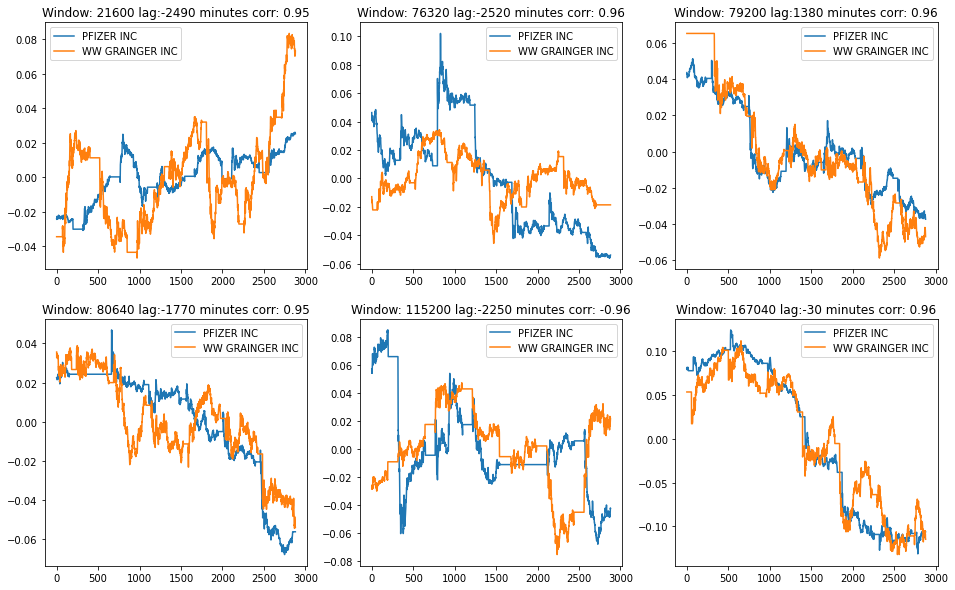

In [78]:
plot_corr_windows(data_pivot.loc[:, symbols_names[0]],
                                    data_pivot.loc[:, symbols_names[2]],
                                    lags_range, lag_step,
                                    window_size, step_size,
                                    arr)

In [35]:
threshold_1_vs_2 = best_lags(df_1_vs_2, arr, threshold=0.95)
threshold_1_vs_2.head()

,window_start,lags
0,0,"[{'lag': -2850, 'corr': -1.0}, {'lag': -2760, ..."
1,1440,"[{'lag': -2850, 'corr': -1.0}, {'lag': -2760, ..."
2,2880,"[{'lag': -2850, 'corr': 1.0}, {'lag': -2820, '..."
3,4320,"[{'lag': -2850, 'corr': -1.0}, {'lag': -2760, ..."
4,5760,"[{'lag': -2730, 'corr': 1.0}, {'lag': 2730, 'c..."


In [79]:
most_common_lags(threshold_1_vs_2)

{2850: 368,
 -2850: 363,
 2760: 310,
 -2760: 303,
 -2730: 296,
 2730: 290,
 2790: 289,
 -2790: 287,
 2700: 286,
 -2700: 282,
 -2820: 280,
 2820: 276,
 2640: 236,
 -2640: 234,
 -2670: 229,
 2670: 229,
 -2430: 105,
 -2400: 101,
 2430: 100,
 -2490: 98,
 -2070: 97,
 -2460: 96,
 2490: 94,
 2460: 94,
 -2370: 93,
 2400: 92,
 2370: 91,
 -2100: 90,
 2100: 89,
 -2520: 87,
 -2160: 87,
 -2130: 87,
 -2610: 86,
 -30: 85,
 2160: 85,
 2520: 85,
 1410: 84,
 2070: 84,
 2130: 83,
 -2580: 80,
 -2190: 79,
 30: 78,
 2610: 77,
 1440: 75,
 2190: 75,
 2010: 74,
 -2040: 73,
 -2010: 72,
 2040: 72,
 -2550: 71,
 1290: 70,
 -2220: 70,
 1380: 70,
 -1290: 69,
 -2340: 69,
 -2280: 68,
 2580: 68,
 1470: 67,
 2340: 67,
 2310: 66,
 -1470: 66,
 -2310: 66,
 1320: 65,
 60: 65,
 -1410: 64,
 2280: 64,
 1170: 64,
 -60: 64,
 2220: 64,
 2550: 64,
 -1440: 64,
 -2250: 63,
 -1860: 62,
 1860: 62,
 1350: 62,
 -1950: 60,
 -1320: 60,
 -930: 60,
 -840: 60,
 840: 60,
 930: 60,
 1950: 60,
 -1380: 60,
 -1020: 59,
 1020: 59,
 -1170: 59,
 -15

In {{ symbols_names[1] }} and {{ symbols_names[2] }} we have rather stromg lag connection.  
We see that maximum lag connection is 368 windows! {{ symbols_names[1] }} leads with vast variety of lag values.

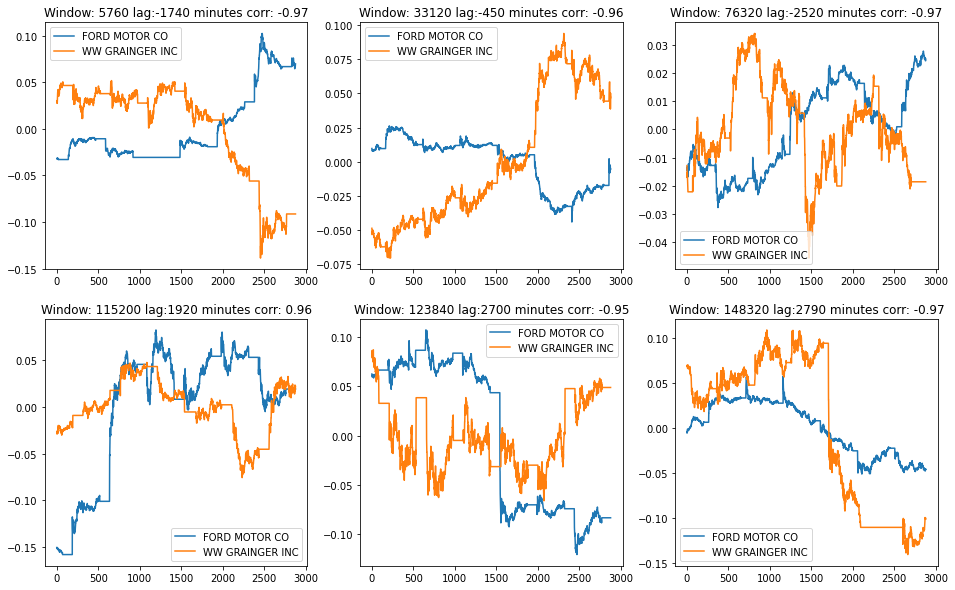

In [80]:
plot_corr_windows(data_pivot.loc[:, symbols_names[1]],
                                    data_pivot.loc[:, symbols_names[2]],
                                    lags_range, lag_step,
                                    window_size, step_size,
                                    arr)

# Conclusion

As was said earlier, there is no constant lag in the data.
But sometimes we can see the lag connection between variables.
For example {{ symbols_names[1] }} are led by {{ symbols_names[2] }}  in lots of windows and there is an opposite connection in almost equal number of windows.
Also, we see that other pairs have a more rare number of high correlations. {{ symbols_names[0] }} and {{ symbols_names[1] }}  pair has a prominent lag connection only for 3 windows for one lag   and {{ symbols_names[0] }} & {{ symbols_names[2] }} pair has 2.

# For future research

* Find number of consequences windows with appropriate correlation threshold
* Look at these prices as signals, i.e. use fft, find dominant frequence ans phase of siglal parts 
* Use other similarity metrics other rather than correlation (cosine distance; peak similarity  etc)